In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
import sklearn.metrics as metrics
import math

In [3]:
sample_submission = pd.read_csv("sample_submission.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
#Creating a copy of the train and test datasets
c_test  = test.copy()
c_train  = train.copy()

In [4]:
c_train['train']  = 1
c_test['train']  = 0
df = pd.concat([c_train, c_test], axis=0,sort=False)

In [5]:
NAN = [(c, df[c].isna().mean()*100) for c in df]
NAN = pd.DataFrame(NAN, columns=["column_name", "percentage"])

In [6]:
NAN = NAN[NAN.percentage > 50]
NAN.sort_values("percentage", ascending=False)

,column_name,percentage
72,PoolQC,99.657417
74,MiscFeature,96.402878
6,Alley,93.216855
73,Fence,80.438506


In [7]:
df = df.drop(['Alley','PoolQC','Fence','MiscFeature'],axis=1)

In [8]:
object_columns_df = df.select_dtypes(include=['object'])
numerical_columns_df =df.select_dtypes(exclude=['object'])

In [9]:
null_counts = object_columns_df.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))

Number of null values in each column:
MSZoning            4
Street              0
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         24
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           81
BsmtCond           82
BsmtExposure       82
BsmtFinType1       79
BsmtFinType2       80
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
KitchenQual         1
Functional          2
FireplaceQu      1420
GarageType        157
GarageFinish      159
GarageQual        159
GarageCond        159
PavedDrive          0
SaleType            1
SaleCondition       0
dtype: int64


In [10]:
columns_None = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','GarageType','GarageFinish','GarageQual','FireplaceQu','GarageCond']
object_columns_df[columns_None]= object_columns_df[columns_None].fillna('None')

/home/rahad/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [11]:
columns_with_lowNA = ['MSZoning','Utilities','Exterior1st','Exterior2nd','MasVnrType','Electrical','KitchenQual','Functional','SaleType']
#fill missing values for each column (using its own most frequent value)
object_columns_df[columns_with_lowNA] = object_columns_df[columns_with_lowNA].fillna(object_columns_df.mode().iloc[0])

In [12]:
null_counts = numerical_columns_df.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))

Number of null values in each column:
Id                  0
MSSubClass          0
LotFrontage       486
LotArea             0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
MasVnrArea         23
BsmtFinSF1          1
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea           0
BsmtFullBath        2
BsmtHalfBath        2
FullBath            0
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
TotRmsAbvGrd        0
Fireplaces          0
GarageYrBlt       159
GarageCars          1
GarageArea          1
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SalePrice        1459
train               0
dtype: int64


In [13]:
print((numerical_columns_df['YrSold']-numerical_columns_df['YearBuilt']).median())
print(numerical_columns_df["LotFrontage"].median())

35.0
68.0


In [14]:
numerical_columns_df['GarageYrBlt'] = numerical_columns_df['GarageYrBlt'].fillna(numerical_columns_df['YrSold']-35)
numerical_columns_df['LotFrontage'] = numerical_columns_df['LotFrontage'].fillna(68)

/home/rahad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/rahad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
numerical_columns_df= numerical_columns_df.fillna(0)

AllPub    2918
NoSeWa       1
Name: Utilities, dtype: int64

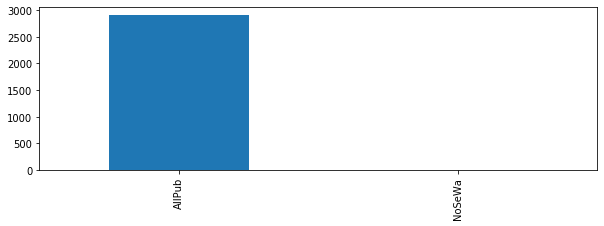

In [16]:
object_columns_df['Utilities'].value_counts().plot(kind='bar',figsize=[10,3])
object_columns_df['Utilities'].value_counts() 

Pave    2907
Grvl      12
Name: Street, dtype: int64

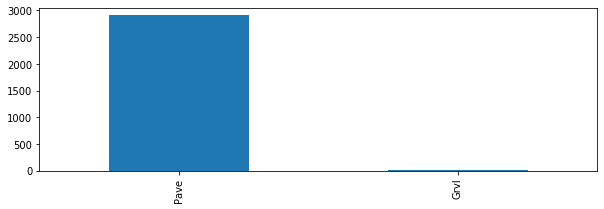

In [17]:
object_columns_df['Street'].value_counts().plot(kind='bar',figsize=[10,3])
object_columns_df['Street'].value_counts() 

Norm      2889
Feedr       13
Artery       5
PosN         4
PosA         4
RRNn         2
RRAe         1
RRAn         1
Name: Condition2, dtype: int64

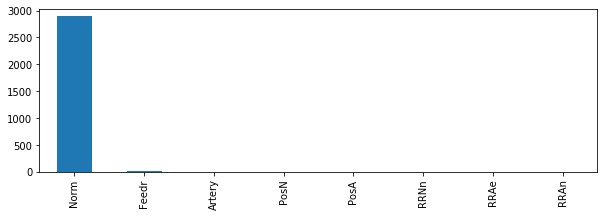

In [18]:
object_columns_df['Condition2'].value_counts().plot(kind='bar',figsize=[10,3])
object_columns_df['Condition2'].value_counts() 

CompShg    2876
Tar&Grv      23
WdShake       9
WdShngl       7
Membran       1
Roll          1
ClyTile       1
Metal         1
Name: RoofMatl, dtype: int64

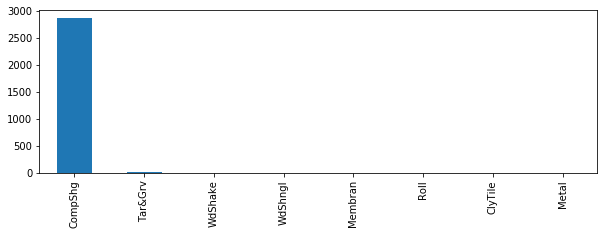

In [19]:
object_columns_df['RoofMatl'].value_counts().plot(kind='bar',figsize=[10,3])
object_columns_df['RoofMatl'].value_counts() 

GasA     2874
GasW       27
Grav        9
Wall        6
OthW        2
Floor       1
Name: Heating, dtype: int64

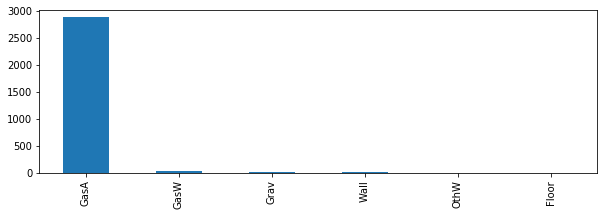

In [20]:
object_columns_df['Heating'].value_counts().plot(kind='bar',figsize=[10,3])
object_columns_df['Heating'].value_counts() #======> Drop feature one Type

In [21]:
object_columns_df = object_columns_df.drop(['Heating','RoofMatl','Condition2','Street','Utilities'],axis=1)

In [22]:
numerical_columns_df['Age_House']= (numerical_columns_df['YrSold']-numerical_columns_df['YearBuilt'])
numerical_columns_df['Age_House'].describe()

count    2919.000000
mean       36.479959
std        30.336182
min        -1.000000
25%         7.000000
50%        35.000000
75%        54.500000
max       136.000000
Name: Age_House, dtype: float64

In [23]:
Negatif = numerical_columns_df[numerical_columns_df['Age_House'] < 0]
Negatif

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,train,Age_House
1089,2550,20,128.0,39290,10,5,2008,2009,1224.0,4010.0,...,0,0,0,0,17000,10,2007,0.0,0,-1


In [24]:
numerical_columns_df.loc[numerical_columns_df['YrSold'] < numerical_columns_df['YearBuilt'],'YrSold' ] = 2009
numerical_columns_df['Age_House']= (numerical_columns_df['YrSold']-numerical_columns_df['YearBuilt'])
numerical_columns_df['Age_House'].describe()

count    2919.000000
mean       36.480644
std        30.335358
min         0.000000
25%         7.000000
50%        35.000000
75%        54.500000
max       136.000000
Name: Age_House, dtype: float64

In [25]:
numerical_columns_df['TotalBsmtBath'] = numerical_columns_df['BsmtFullBath'] + numerical_columns_df['BsmtFullBath']*0.5
numerical_columns_df['TotalBath'] = numerical_columns_df['FullBath'] + numerical_columns_df['HalfBath']*0.5 
numerical_columns_df['TotalSA']=numerical_columns_df['TotalBsmtSF'] + numerical_columns_df['1stFlrSF'] + numerical_columns_df['2ndFlrSF']

In [26]:
bin_map  = {'TA':2,'Gd':3, 'Fa':1,'Ex':4,'Po':1,'None':0,'Y':1,'N':0,'Reg':3,'IR1':2,'IR2':1,'IR3':0,"None" : 0,
            "No" : 2, "Mn" : 2, "Av": 3,"Gd" : 4,"Unf" : 1, "LwQ": 2, "Rec" : 3,"BLQ" : 4, "ALQ" : 5, "GLQ" : 6
            }
object_columns_df['ExterQual'] = object_columns_df['ExterQual'].map(bin_map)
object_columns_df['ExterCond'] = object_columns_df['ExterCond'].map(bin_map)
object_columns_df['BsmtCond'] = object_columns_df['BsmtCond'].map(bin_map)
object_columns_df['BsmtQual'] = object_columns_df['BsmtQual'].map(bin_map)
object_columns_df['HeatingQC'] = object_columns_df['HeatingQC'].map(bin_map)
object_columns_df['KitchenQual'] = object_columns_df['KitchenQual'].map(bin_map)
object_columns_df['FireplaceQu'] = object_columns_df['FireplaceQu'].map(bin_map)
object_columns_df['GarageQual'] = object_columns_df['GarageQual'].map(bin_map)
object_columns_df['GarageCond'] = object_columns_df['GarageCond'].map(bin_map)
object_columns_df['CentralAir'] = object_columns_df['CentralAir'].map(bin_map)
object_columns_df['LotShape'] = object_columns_df['LotShape'].map(bin_map)
object_columns_df['BsmtExposure'] = object_columns_df['BsmtExposure'].map(bin_map)
object_columns_df['BsmtFinType1'] = object_columns_df['BsmtFinType1'].map(bin_map)
object_columns_df['BsmtFinType2'] = object_columns_df['BsmtFinType2'].map(bin_map)

PavedDrive =   {"N" : 0, "P" : 1, "Y" : 2}
object_columns_df['PavedDrive'] = object_columns_df['PavedDrive'].map(PavedDrive)

In [27]:
#Select categorical features
rest_object_columns = object_columns_df.select_dtypes(include=['object'])
#Using One hot encoder
object_columns_df = pd.get_dummies(object_columns_df, columns=rest_object_columns.columns) 

In [28]:
df_final = pd.concat([object_columns_df, numerical_columns_df], axis=1,sort=False)
df_final.head()

,LotShape,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,...,PoolArea,MiscVal,MoSold,YrSold,SalePrice,train,Age_House,TotalBsmtBath,TotalBath,TotalSA
0,3,4,2,4,2,2,6,1,4,1,...,0,0,2,2008,208500.0,1,5,1.5,2.5,2566.0
1,3,2,2,4,2,4,5,1,4,1,...,0,0,5,2007,181500.0,1,31,0.0,2.0,2524.0
2,2,4,2,4,2,2,6,1,4,1,...,0,0,9,2008,223500.0,1,7,1.5,2.5,2706.0
3,2,2,2,2,4,2,5,1,4,1,...,0,0,2,2006,140000.0,1,91,1.5,1.0,2473.0
4,2,4,2,4,2,3,6,1,4,1,...,0,0,12,2008,250000.0,1,8,1.5,2.5,3343.0


In [29]:
df_final = df_final.drop(['Id',],axis=1)

df_train = df_final[df_final['train'] == 1]
df_train = df_train.drop(['train',],axis=1)


df_test = df_final[df_final['train'] == 0]
df_test = df_test.drop(['SalePrice'],axis=1)
df_test = df_test.drop(['train',],axis=1)

In [30]:
target= df_train['SalePrice']
df_train = df_train.drop(['SalePrice'],axis=1)

In [31]:
x_train,x_test,y_train,y_test = train_test_split(df_train,target,test_size=0.33,random_state=0)

In [32]:
xgb =XGBRegressor( booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0,
             importance_type='gain', learning_rate=0.02, max_delta_step=0,
             max_depth=4, min_child_weight=1.5, n_estimators=2500,
             n_jobs=1, nthread=None, objective='reg:linear',
             reg_alpha=0.6, reg_lambda=0.6, scale_pos_weight=1, 
             silent=None, subsample=0.8, verbosity=1)


lgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=12000, 
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.4, 
                                       )

In [33]:
xgb.fit(x_train, y_train)
lgbm.fit(x_train, y_train,eval_metric='rmse')

[01:57:58] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:58:17] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


LGBMRegressor(bagging_fraction=0.75, bagging_freq=5, bagging_seed=7,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.4, importance_type='split', learning_rate=0.01,
              max_bin=200, max_depth=-1, min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=12000,
              n_jobs=-1, num_leaves=4, objective='regression',
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [34]:
predict1 = xgb.predict(x_test)
predict = lgbm.predict(x_test)

In [35]:
print('Root Mean Square Error test = ' + str(math.sqrt(metrics.mean_squared_error(y_test, predict1))))
print('Root Mean Square Error test = ' + str(math.sqrt(metrics.mean_squared_error(y_test, predict))))

Root Mean Square Error test = 26863.920379054696
Root Mean Square Error test = 26726.198278903514


In [36]:
xgb.fit(df_train, target)
lgbm.fit(df_train, target,eval_metric='rmse')

[01:58:24] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:58:49] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


LGBMRegressor(bagging_fraction=0.75, bagging_freq=5, bagging_seed=7,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.4, importance_type='split', learning_rate=0.01,
              max_bin=200, max_depth=-1, min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=12000,
              n_jobs=-1, num_leaves=4, objective='regression',
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [37]:
predict4 = lgbm.predict(df_test)
predict3 = xgb.predict(df_test)
predict_y = ( predict3*0.45 + predict4 * 0.55)

In [38]:
submission = pd.DataFrame({
        "Id": test["Id"],
        "SalePrice": predict_y
    })
submission.to_csv('submission.csv', index=False)

In [40]:
submission

,Id,SalePrice
0,1461,126575.845425
1,1462,166347.780363
2,1463,185687.612440
3,1464,191566.164237
4,1465,186615.297207
...,...,...
1454,2915,82708.358916
1455,2916,80210.248376
1456,2917,164419.643446
1457,2918,119798.828981
